In [9]:
import csv
import datetime
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [10]:
LOGDIR = '../philly-traces/trace-data'
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

In [11]:
def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

def timedelta_to_minutes(timedelta):
    """Converts a datetime timedelta object to minutes.
    
       Args:
           timedelta: The timedelta to convert.
           
       Returns:
           The number of minutes captured in the timedelta.
    """
    minutes = 0.0
    minutes += timedelta.days * MINUTES_PER_DAY
    minutes += timedelta.seconds / 60.0
    minutes += timedelta.microseconds / MICROSECONDS_PER_MINUTE
    return minutes

def round_to_nearest_minute(t):
    """Rounds a datetime object down to the nearest minute.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new rounded down datetime object.
    """
    return t - datetime.timedelta(seconds=t.second, microseconds=t.microsecond)

def add_minute(t):
    """Adds a single minute to a datetime object.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new datetime object with an additional minute.
    """
    return t + datetime.timedelta(seconds=60)

In [12]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [13]:
class JobTrace:
    """Encapsulates a job."""
    
    def __init__(self, status, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = \
                        timedelta_to_minutes(self._attempts[-1]['end_time'] -
                                             self._attempts[0]['start_time'])
                self._queueing_delay = \
                    timedelta_to_minutes(self._attempts[0]['start_time'] -
                                         self._submitted_time)
    
    def __repr__(self):
        return (f'Job(job_id={self._jobid},\n'
                f'user={self._user},\n'
                f'status={self._status},\n'
                f'num_gpus = {self._num_gpus},\n'
                f'submitted_time = {self._submitted_time},\n'
                f'run_time={self._run_time}\n'
                f'attempts={self._attempts})')
    
    @property
    def status(self):
        return self._status
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

In [14]:
def get_bucket_from_num_gpus(num_gpus):
    """Maps GPU count to a bucket for plotting purposes."""
    if num_gpus is None:
        return None
    if num_gpus == 1:
        return 0
    elif num_gpus >= 2 and num_gpus <= 4:
        return 1
    elif num_gpus >= 5 and num_gpus <= 8:
        return 2
    elif num_gpus > 8:
        return 3
    else:
        return None
    
def get_plot_config_from_bucket(bucket):
    """Returns plotting configuration information."""
    if bucket == 0:
        return ('1', 'green', '-')
    elif bucket == 1:
        return ('2-4', 'blue', '-.')
    elif bucket == 2:
        return ('5-8', 'red', '--')
    elif bucket == 3:
        return ('>8', 'purple', ':')

In [15]:
cluster_job_log_path = os.path.join(LOGDIR, 'cluster_job_log')
with open(cluster_job_log_path, 'r') as f:
    cluster_job_log = json.load(f)
jobs = [JobTrace(status=job['status'], jobid=job['jobid'], attempts=job['attempts'], submitted_time=job['submitted_time'], user=job['user']) for job in cluster_job_log]
jobs = sorted(jobs, key=lambda t: t._submitted_time)

In [16]:
print(jobs[0:1000])

[Job(job_id=application_1501012364013_9680,
user=a547a3,
status=Killed,
num_gpus = 1,
submitted_time = 2017-08-07 10:03:01,
run_time=None
attempts=[{'start_time': None, 'end_time': datetime.datetime(2017, 9, 12, 18, 15, 6), 'detail': [{'ip': 'm345', 'gpus': ['gpu0']}]}, {'start_time': datetime.datetime(2017, 9, 12, 18, 15, 16), 'end_time': datetime.datetime(2017, 9, 28, 20, 9, 19), 'detail': [{'ip': 'm180', 'gpus': ['gpu0']}]}]), Job(job_id=application_1501012364013_12103,
user=e90b30,
status=Pass,
num_gpus = 8,
submitted_time = 2017-08-10 05:03:18,
run_time=None
attempts=[{'start_time': None, 'end_time': datetime.datetime(2017, 9, 14, 22, 11, 27), 'detail': [{'ip': 'm192', 'gpus': ['gpu0', 'gpu1', 'gpu2', 'gpu3', 'gpu4', 'gpu5', 'gpu6', 'gpu7']}]}]), Job(job_id=application_1501012364013_13756,
user=ce36f0,
status=Killed,
num_gpus = None,
submitted_time = 2017-08-11 19:13:46,
run_time=None
attempts=[]), Job(job_id=application_1501012364013_13883,
user=e90b30,
status=Failed,
num_gpus = 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


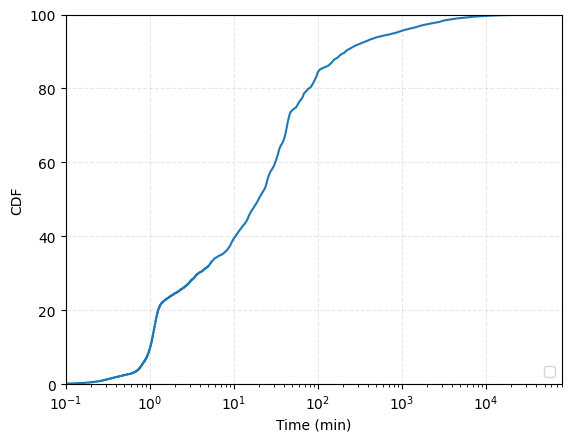

In [17]:
# Plotting Job CDF for Phillly Trace
run_times = []
for j in jobs:
    if j._run_time is not None and j.status=='Pass':
        run_times.append(j._run_time)
run_times.sort()
#print(run_times)

# buckets = sorted([bucket for bucket in run_times])
# for bucket in buckets:
#     num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
x, y = get_cdf(run_times)
plt.plot(x, y)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlim(10 ** -1, 8* 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

In [88]:
# Problem V0: Global Deadline, jobs run on one node

# Ensure max runtime is 100 hours for jobs (off of Philly trace)
#run_times = [r for r in run_times if r<=6000.0]

from random import choices
subsampled_run_times = [r for r in run_times if r <=6000]
subsampled_run_times =  [r/60.0 for r in choices(subsampled_run_times, k=2048)]
subsampled_run_times.sort()
print(subsampled_run_times)
print(sum(subsampled_run_times)/16.0)

[0.0002777777777777778, 0.0008333333333333334, 0.0011111111111111111, 0.0019444444444444444, 0.0022222222222222222, 0.0027777777777777775, 0.0027777777777777775, 0.0030555555555555553, 0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335, 0.0036111111111111114, 0.0036111111111111114, 0.0038888888888888888, 0.0044444444444444444, 0.004722222222222222, 0.004722222222222222, 0.004722222222222222, 0.005, 0.005, 0.005277777777777778, 0.005277777777777778, 0.005555555555555555, 0.005555555555555555, 0.005555555555555555, 0.005555555555555555, 0.005555555555555555, 0.005833333333333333, 0.005833333333333333, 0.0061111111111111106, 0.0061111111111111106, 0.006388888888888889, 0.006944444444444445, 0.006944444444444445, 0.006944444444444445, 0.007222222222222223, 0.007222222222222223, 0.007222222222222223, 0.007500000000000001, 0.007500000000000001, 0.0077777777777777776, 0.008333333333333333, 0.008333333333333333, 0.008333333333333333, 0.008888888888888889

In [92]:
def longest_job_first(run_times, num_nodes, global_deadline):
    # Longest Job First - Sorts jobs by longest runtimes and greedily packs into nodes.
    run_times = run_times.copy()
    run_times.sort(reverse=True)
    num_nodes_capacity = [0.0] * num_nodes
    num_nodes_jobs = [[]]*num_nodes
    cloud_cost = sum(run_times)
    for time in run_times:
        bin_idx = 0
        min_bin_idx = num_nodes_capacity.index(min(num_nodes_capacity))
        # Place in bin with least capacity
        if global_deadline - num_nodes_capacity[min_bin_idx] >= time:
            num_nodes_capacity[min_bin_idx] += time
            num_nodes_jobs[min_bin_idx].append(time)
            cloud_cost -= time
    return cloud_cost, num_nodes_capacity
    
def shortest_job_first(run_times, num_nodes, global_deadline):
    # Shortest Job First - Sorts jobs by shortest runtimes and greedily packs into nodes.
    run_times = run_times.copy()
    run_times.sort()
    num_nodes_capacity = [0.0] * num_nodes
    num_nodes_jobs = [[]]*num_nodes
    cloud_cost = sum(run_times)
    for time in run_times:
        bin_idx = 0
        min_bin_idx = num_nodes_capacity.index(min(num_nodes_capacity))
        # Place in bin with least capacity
        if global_deadline - num_nodes_capacity[min_bin_idx] >= time:
            num_nodes_capacity[min_bin_idx] += time
            num_nodes_jobs[min_bin_idx].append(time)
            cloud_cost -= time
    return cloud_cost, num_nodes_capacity

def ilp_solver_v0(run_times, num_nodes, global_deadline):
    import cvxpy
    import numpy as np
    run_times = run_times.copy()
    num_jobs = len(run_times)
    weights = np.array(run_times).reshape((num_jobs, 1))
    utilities = np.array(run_times).reshape((num_jobs, 1))
    global_deadline = np.array([global_deadline] * num_nodes).reshape((num_nodes, 1))

    # Optimization varaibles that indicates 0/1 if job goes to node_idx
    selection = cvxpy.Variable((num_nodes, num_jobs), boolean=True)

    # The sum of the weights should be less than or equal to the deadline
    weight_constraint = selection@weights  <= global_deadline
    
    bin_constraint = cvxpy.sum(selection, axis=0) <= 1

    # Our total utility is the sum of the item utilities
    total_utility = cvxpy.sum(selection@utilities)

    # We tell cvxpy that we want to maximize total utility 
    # subject to weight_constraint. All constraints in 
    # cvxpy must be passed as a list
    multi_knapsack_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), [weight_constraint, bin_constraint])

    # Solving the problem
    opts = {'limits/time' : 600} #{'maxiters' : 5000}
    multi_knapsack_problem.solve(solver=cvxpy.SCIP, verbose=False, scip_params = opts)
    
    solution = selection.value
    total_weight = solution @ weights
    return sum(run_times) - np.sum(total_weight), total_weight.reshape((num_nodes, ))

cluster_size = [2, 4, 8, 16, 32]
cluster_size = [4]
deadline_fraction = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2]
deadlines = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250]
# cluster_size = [2, 4]
# deadline_fraction = [1.05, 1.00]


from multiprocessing.pool import Pool
from multiprocessing import Lock
import multiprocessing

# def apply_solver(v0_results, cluster_size, deadline):
#     print(f'{cluster_size} + {deadline}\n')
#     sjf_results = shortest_job_first(subsampled_run_times, cluster_size, max_deadline*deadline)
#     ljf_results = longest_job_first(subsampled_run_times, cluster_size, max_deadline*deadline)
#     ilp_results = ilp_solver_v0(subsampled_run_times, cluster_size, max_deadline*deadline)
#     v0_results[(cluster_size, deadline, 'sjf')] = sjf_results[0]
#     v0_results[(cluster_size, deadline, 'ljf')] = ljf_results[0]
#     v0_results[(cluster_size, deadline, 'ilp')] = ilp_results[0]
#     print(dict(v0_results))

# with multiprocessing.Manager() as manager:
#     input_tuples = []
#     # Parallel version
#     v0_results = manager.dict()
#     for c_size in cluster_size:
#         for ddl in deadline_fraction:
#             input_tuples.append((v0_results, c_size, ddl))
#     with Pool(processes=len(input_tuples)) as pool:
#         pool.starmap(apply_solver, input_tuples)
#     total_results = dict(v0_results)
    

def apply_strict_solver(v0_results, cluster_size, deadline):
    print(f'{cluster_size} + {deadline}\n')
    sjf_results = shortest_job_first(subsampled_run_times, cluster_size, deadline)
    ljf_results = longest_job_first(subsampled_run_times, cluster_size, deadline)
    ilp_results = ilp_solver_v0(subsampled_run_times, cluster_size, deadline)
    v0_results[(cluster_size, deadline, 'sjf')] = sjf_results[0]
    v0_results[(cluster_size, deadline, 'ljf')] = ljf_results[0]
    v0_results[(cluster_size, deadline, 'ilp')] = ilp_results[0]
    print(dict(v0_results))

with multiprocessing.Manager() as manager:
    input_tuples = []
    # Parallel version
    v0_results = manager.dict()
    for c_size in cluster_size:
        for ddl in deadlines:
            input_tuples.append((v0_results, c_size, ddl))
    with Pool(processes=len(input_tuples)) as pool:
        pool.starmap(apply_strict_solver, input_tuples)
    total_results = dict(v0_results)


4 + 50
4 + 25
4 + 100
4 + 75
4 + 175





4 + 125
4 + 225
4 + 150
4 + 250



4 + 200
4 + 275



4 + 450
4 + 300
4 + 350
4 + 325
4 + 400


4 + 500



4 + 700
4 + 550
4 + 600



4 + 650
4 + 800
4 + 750



4 + 850


4 + 950
4 + 900
4 + 1000
4 + 1200



4 + 1050


4 + 1100
4 + 1150
4 + 1250



{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13}
{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133}
{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133, (4, 275, 'sjf'): 3774.4405555555486, (4, 275, 'ljf'): 3760.349722222233, (4, 275, 'ilp'): 3760.3486111111133}
{(4, 1250, 'sjf')

{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133, (4, 275, 'sjf'): 3774.4405555555486, (4, 275, 'ljf'): 3760.349722222233, (4, 275, 'ilp'): 3760.3486111111133, (4, 50, 'sjf'): 4661.546111111101, (4, 50, 'ljf'): 4660.349444444455, (4, 50, 'ilp'): 4660.348611111113, (4, 325, 'sjf'): 3582.945555555549, (4, 325, 'ljf'): 3560.3494444444545, (4, 325, 'ilp'): 3560.3486111111133, (4, 25, 'sjf'): 4761.0411111111025, (4, 25, 'ljf'): 4760.349722222232, (4, 25, 'ilp'): 4760.348611111113, (4, 75, 'sjf'): 4561.541666666653, (4, 75, 'ljf'): 4560.349444444455, (4, 75, 'ilp'): 4560.348611111113, (4, 100, 'sjf'): 4461.933611111094, (4, 100, 'ljf'): 4460.349166666678, (4, 100, 'ilp'): 4460.348611111113, (4, 250, 'sjf'): 3868.659444444437, (4, 250, 'ljf'): 3860.3488888889, (4, 250, 'ilp'): 3860.3486111111133, (4, 200, 'sjf'): 4

{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133, (4, 275, 'sjf'): 3774.4405555555486, (4, 275, 'ljf'): 3760.349722222233, (4, 275, 'ilp'): 3760.3486111111133, (4, 50, 'sjf'): 4661.546111111101, (4, 50, 'ljf'): 4660.349444444455, (4, 50, 'ilp'): 4660.348611111113, (4, 325, 'sjf'): 3582.945555555549, (4, 325, 'ljf'): 3560.3494444444545, (4, 325, 'ilp'): 3560.3486111111133, (4, 25, 'sjf'): 4761.0411111111025, (4, 25, 'ljf'): 4760.349722222232, (4, 25, 'ilp'): 4760.348611111113, (4, 75, 'sjf'): 4561.541666666653, (4, 75, 'ljf'): 4560.349444444455, (4, 75, 'ilp'): 4560.348611111113, (4, 100, 'sjf'): 4461.933611111094, (4, 100, 'ljf'): 4460.349166666678, (4, 100, 'ilp'): 4460.348611111113, (4, 250, 'sjf'): 3868.659444444437, (4, 250, 'ljf'): 3860.3488888889, (4, 250, 'ilp'): 3860.3486111111133, (4, 200, 'sjf'): 4

{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133, (4, 275, 'sjf'): 3774.4405555555486, (4, 275, 'ljf'): 3760.349722222233, (4, 275, 'ilp'): 3760.3486111111133, (4, 50, 'sjf'): 4661.546111111101, (4, 50, 'ljf'): 4660.349444444455, (4, 50, 'ilp'): 4660.348611111113, (4, 325, 'sjf'): 3582.945555555549, (4, 325, 'ljf'): 3560.3494444444545, (4, 325, 'ilp'): 3560.3486111111133, (4, 25, 'sjf'): 4761.0411111111025, (4, 25, 'ljf'): 4760.349722222232, (4, 25, 'ilp'): 4760.348611111113, (4, 75, 'sjf'): 4561.541666666653, (4, 75, 'ljf'): 4560.349444444455, (4, 75, 'ilp'): 4560.348611111113, (4, 100, 'sjf'): 4461.933611111094, (4, 100, 'ljf'): 4460.349166666678, (4, 100, 'ilp'): 4460.348611111113, (4, 250, 'sjf'): 3868.659444444437, (4, 250, 'ljf'): 3860.3488888889, (4, 250, 'ilp'): 3860.3486111111133, (4, 200, 'sjf'): 4

{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133, (4, 275, 'sjf'): 3774.4405555555486, (4, 275, 'ljf'): 3760.349722222233, (4, 275, 'ilp'): 3760.3486111111133, (4, 50, 'sjf'): 4661.546111111101, (4, 50, 'ljf'): 4660.349444444455, (4, 50, 'ilp'): 4660.348611111113, (4, 325, 'sjf'): 3582.945555555549, (4, 325, 'ljf'): 3560.3494444444545, (4, 325, 'ilp'): 3560.3486111111133, (4, 25, 'sjf'): 4761.0411111111025, (4, 25, 'ljf'): 4760.349722222232, (4, 25, 'ilp'): 4760.348611111113, (4, 75, 'sjf'): 4561.541666666653, (4, 75, 'ljf'): 4560.349444444455, (4, 75, 'ilp'): 4560.348611111113, (4, 100, 'sjf'): 4461.933611111094, (4, 100, 'ljf'): 4460.349166666678, (4, 100, 'ilp'): 4460.348611111113, (4, 250, 'sjf'): 3868.659444444437, (4, 250, 'ljf'): 3860.3488888889, (4, 250, 'ilp'): 3860.3486111111133, (4, 200, 'sjf'): 4

{(16, 325, 'sjf'): 462.8686111111033, (16, 325, 'ljf'): 0, (16, 325, 'ilp'): 0, (16, 200, 'sjf'): 2043.213055555548, (16, 200, 'ljf'): 1660.3530555555647, (16, 200, 'ilp'): 1660.3486111111133, (16, 250, 'sjf'): 1284.3052777777702, (16, 250, 'ljf'): 860.3544444444526, (16, 250, 'ilp'): 860.3486111111133, (16, 50, 'sjf'): 4081.8613888888804, (16, 50, 'ljf'): 4060.354444444457, (16, 50, 'ilp'): 4060.3486111111133, (16, 125, 'sjf'): 3012.81916666666, (16, 125, 'ljf'): 2860.35250000001, (16, 125, 'ilp'): 2860.3486111111133, (16, 75, 'sjf'): 3708.355833333327, (16, 75, 'ljf'): 3660.3522222222346, (16, 75, 'ilp'): 3660.351388888891, (16, 25, 'sjf'): 4467.791388888872, (16, 25, 'ljf'): 4460.352222222235, (16, 25, 'ilp'): 4460.349444444447, (16, 300, 'sjf'): 712.2202777777701, (16, 300, 'ljf'): 60.353055555563145, (16, 300, 'ilp'): 60.35361111111342, (16, 225, 'sjf'): 1708.4741666666591, (16, 225, 'ljf'): 1260.353333333342, (16, 225, 'ilp'): 1260.3494444444468, (16, 150, 'sjf'): 2684.0388888888

KeyError: (32, 25, 'ilp')

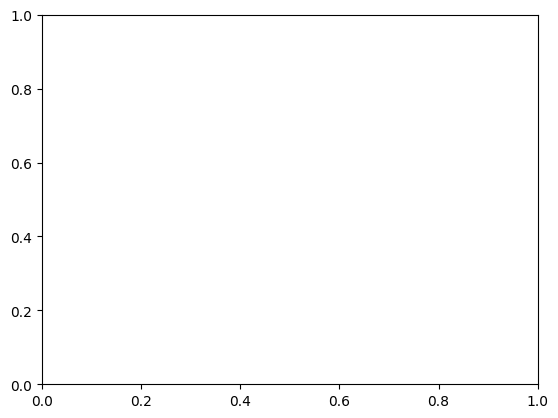

In [87]:
import matplotlib.pyplot as plt
import numpy as np

results = total_results.copy()
for r in results.keys():
    if abs(results[r]) < 1e-5:
        results[r] = 0

print(results)
fig, ax = plt.subplots()

a = []
import math
#cluster_size = [2, 4, 8, 16, 32]
cluster_size = [4]
deadline_fraction = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2]
deadline_fraction = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325]
for clus_size in reversed(cluster_size):
    b = []
    for ddl in deadline_fraction:
        ilp_results = results[(clus_size, ddl, 'ilp')]
        ljf_results = results[(clus_size, ddl, 'ljf')]
        
        if ilp_results == 0 and ljf_results ==0:
            fraction = 1
        elif ilp_results == 0:
            fraction = 2
        else:
            fraction = ljf_results/ilp_results
        b.append(fraction)
    a.append(b)

print(a)
plt.imshow(a, interpolation='nearest')

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95', '1', '1.05', '1.1', '1.15', '1.2']
ax.set_xticklabels(labels)


labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['', '32', '16', '8', '4', '2']
ax.set_yticklabels(labels)

plt.xlabel('Global Deadline')

plt.ylabel('Number of Local Nodes')

plt.title('LJF/ILP Ratio')
plt.show()

In [93]:
print(total_results)
import pickle 
import math 
file_pi = open('logs/4.obj', 'wb') 
pickle.dump(total_results, file_pi)

{(4, 1250, 'sjf'): 94.67805555554773, (4, 1250, 'ljf'): 7.615259768264937e-12, (4, 1250, 'ilp'): 9.094947017729282e-13, (4, 500, 'sjf'): 2907.0591666666596, (4, 500, 'ljf'): 2860.3497222222327, (4, 500, 'ilp'): 2860.3486111111133, (4, 275, 'sjf'): 3774.4405555555486, (4, 275, 'ljf'): 3760.349722222233, (4, 275, 'ilp'): 3760.3486111111133, (4, 50, 'sjf'): 4661.546111111101, (4, 50, 'ljf'): 4660.349444444455, (4, 50, 'ilp'): 4660.348611111113, (4, 325, 'sjf'): 3582.945555555549, (4, 325, 'ljf'): 3560.3494444444545, (4, 325, 'ilp'): 3560.3486111111133, (4, 25, 'sjf'): 4761.0411111111025, (4, 25, 'ljf'): 4760.349722222232, (4, 25, 'ilp'): 4760.348611111113, (4, 75, 'sjf'): 4561.541666666653, (4, 75, 'ljf'): 4560.349444444455, (4, 75, 'ilp'): 4560.348611111113, (4, 100, 'sjf'): 4461.933611111094, (4, 100, 'ljf'): 4460.349166666678, (4, 100, 'ilp'): 4460.348611111113, (4, 250, 'sjf'): 3868.659444444437, (4, 250, 'ljf'): 3860.3488888889, (4, 250, 'ilp'): 3860.3486111111133, (4, 200, 'sjf'): 4

     nodes  deadline  alg          cost alg-nodes
0        4      1250  sjf  9.467806e+01     sjf-4
1        4      1250  ljf  7.615260e-12     ljf-4
2        4      1250  ilp  9.094947e-13     ilp-4
3        4       500  sjf  2.907059e+03     sjf-4
4        4       500  ljf  2.860350e+03     ljf-4
..     ...       ...  ...           ...       ...
229     32       125  ljf  8.603703e+02    ljf-32
230     32       125  ilp  8.603617e+02    ilp-32
231     32        25  sjf  4.101959e+03    sjf-32
232     32        25  ljf  4.060358e+03    ljf-32
233     32        25  ilp  4.060358e+03    ilp-32

[234 rows x 5 columns]


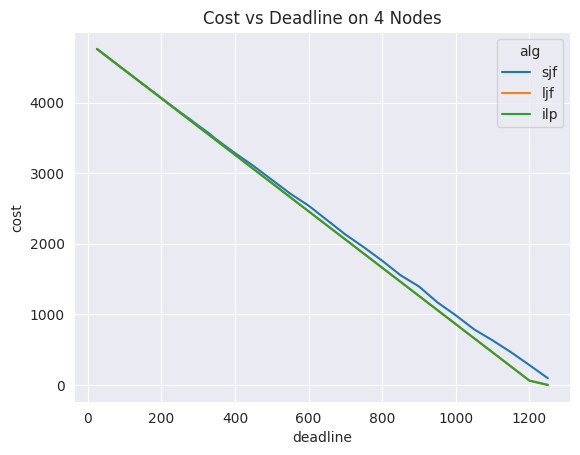

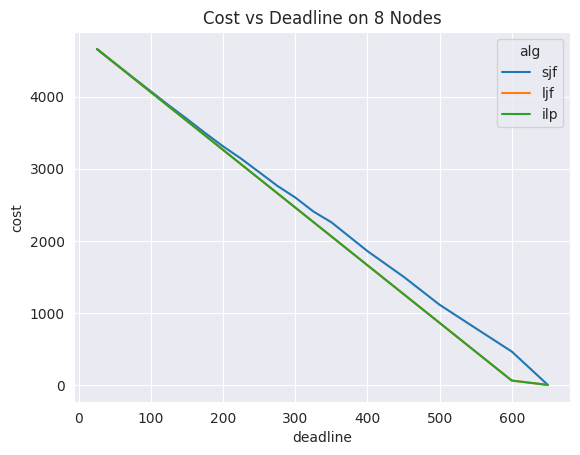

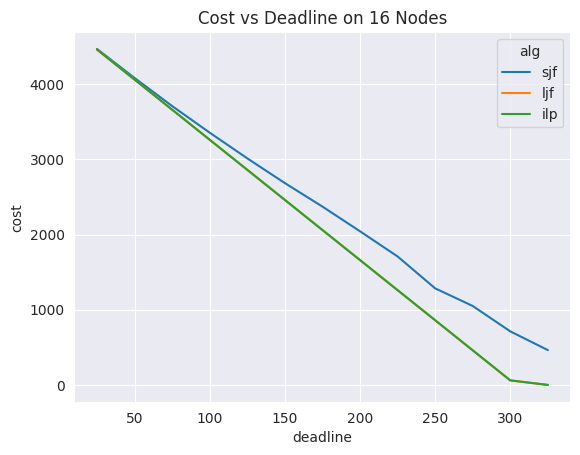

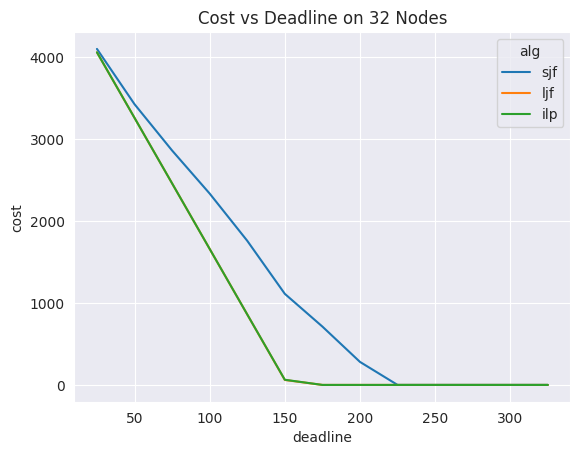

In [53]:
import pickle 
import math 
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
cluster_sizes = [4,8,16,32]

total_list = []
for c in cluster_sizes:
    file = open(f"v0_logs/{c}.obj",'rb')
    object_file = pickle.load(file)
    for o in object_file.keys():
        total_list.append([o[0], o[1], o[2], object_file[o]])
df = pd.DataFrame(total_list, columns=['nodes', 'deadline', 'alg', 'cost'])
df['alg-nodes'] =df[['alg', 'nodes']].astype(str).apply('-'.join,1)
print(df)
for c in cluster_sizes:
    sns.lineplot(x = "deadline", y = "cost", data=df[df['nodes']==c], hue="alg")
    plt.title(f'Cost vs Deadline on {c} Nodes')
    plt.show()

0     737.306666
1       0.000039
2       0.000030
3       0.000018
4       0.000023
         ...    
73     -0.002208
74     -4.069398
75     -0.000147
76      0.001001
77      0.000007
Name: ljf-ilp, Length: 78, dtype: float64


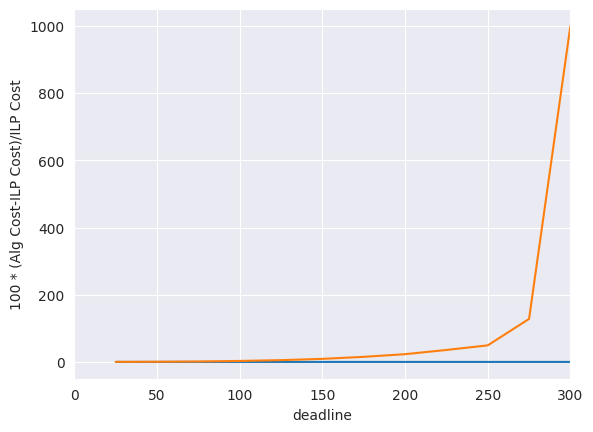

In [90]:
df_ilp = df[df['alg']=='ilp']
del df_ilp['alg-nodes']
df_ljf = df[df['alg']=='ljf']
del df_ljf['alg-nodes']
df_sjf = df[df['alg']=='sjf']
del df_sjf['alg-nodes']

result = pd.merge(pd.merge(df_ljf, df_ilp, on=["nodes", "deadline"]), df_sjf, on=['nodes', 'deadline'])
result['ljf-ilp'] = 100.0 * (result['cost_x'] - result['cost_y'])/result['cost_y']
print(result['ljf-ilp'] )
result['ljf-ilp'] = result['ljf-ilp'].clip(upper=1000)
result['sjf-ilp'] = 100.0* (result['cost'] - result['cost_y'])/result['cost_y']
result['sjf-ilp'] = result['sjf-ilp'].clip(upper=1000)
sns.lineplot(x = "deadline", y = "ljf-ilp", data=result[result['nodes']==16])
sns.lineplot(x = "deadline", y = "sjf-ilp", data=result[result['nodes']==16])
plt.ylabel('100 * (Alg Cost-ILP Cost)/ILP Cost')
plt.xlim(0, 300)
plt.show()